In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import GPE_ensemble as GPE

#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion, 
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion

import scipy

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 8
#set_seed(seed)

In [2]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None)

In [3]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)

In [4]:
y_labels

,0
0,A_TAT
1,V_TAT


In [5]:
inputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/01/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/01/Y.txt",index_col=None,delim_whitespace=True,header=None).values

inputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/02/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/02/Y.txt",index_col=None,delim_whitespace=True,header=None).values

X0 = pd.DataFrame(inputData_0)
Y0 = pd.DataFrame(outputData_0)

X1 = pd.DataFrame(inputData_1)
Y1 = pd.DataFrame(outputData_1)

X0.columns=x_labels
X1.columns=x_labels

Y0.columns = y_labels
Y1.columns = y_labels

In [54]:
emulator_0 = GPE.ensemble(X0,Y0,mean_func="constant",training_iter=0)

0
1


In [55]:
for param in emulator_0.models[0].named_parameters():
    print(f' value = {param}')

 value = ('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
 value = ('mean_module.raw_constant', Parameter containing:
tensor(0., requires_grad=True))
 value = ('covar_module.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True))
 value = ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0., 0., 0., 0., 0., 0.]], requires_grad=True))


In [62]:
emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=0)

0
1


In [63]:
for param in emulator_0.models[0].named_parameters():
    print(f' value = {param}')

 value = ('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
 value = ('mean_module.weights', Parameter containing:
tensor([[ 0.0853],
        [ 0.3887],
        [ 0.4951],
        [ 0.1363],
        [-0.0307],
        [-0.1621]], requires_grad=True))
 value = ('mean_module.bias', Parameter containing:
tensor([0.1782], requires_grad=True))
 value = ('covar_module.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True))
 value = ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0., 0., 0., 0., 0., 0.]], requires_grad=True))


In [15]:
# split original dataset in training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X1,
    Y1,
    test_size=0.1,
    random_state=seed
)

In [16]:
X_test.shape[1]

6

In [17]:
a=np.random.choice(range(X_train.shape[0]),18,replace=False)

In [18]:
X_train.iloc[a]

,"(CV_ventricles,)","(k_ventricles,)","(k_FEC,)","(CV_atria,)","(k_atria,)","(k_BB,)"
7,0.715174,0.244879,6.58943,0.945305,0.459602,3.99970
146,0.709601,0.281467,8.13502,0.883186,0.350238,3.74937
8,0.579824,0.430775,7.94578,0.900611,0.371278,1.58024
111,0.623707,0.408672,8.39069,0.494697,0.253064,1.88319
54,0.460794,0.429316,2.30789,0.458134,0.312600,1.47405
154,0.467959,0.400387,4.30257,0.301141,0.287728,4.49762
18,0.522433,0.299030,5.15199,0.932090,0.360966,4.49964
87,0.693558,0.463414,7.29527,0.997660,0.496963,5.17234
139,0.383140,0.361535,2.99392,1.005820,0.248249,1.55373
0,0.562480,0.467546,3.32121,0.332131,0.495330,4.84212


In [19]:
X_train.shape

(162, 6)

In [20]:
m0 = emulator_0.predict(X_train.iloc[a])

In [21]:
y_adjust = pd.DataFrame((torch.tensor(y_train.iloc[a].values) - m0).detach().numpy())

In [22]:
delta_1 = GPE.ensemble(X_train.iloc[a],y_adjust,mean_func="linear",training_iter=500)

0
1


In [23]:
np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0).detach().numpy())

array([6.79400965, 1.94997895])

In [24]:
1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0)/torch.tensor(np.var(y_test.values,axis=0))

tensor([0.9872, 0.9949], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [25]:
p = int(X1.shape[0]*0.05)
n = int(X_train.shape[0]/p)
reps = 10
MSE = np.zeros((n,reps,2))
R2 = np.zeros((n,reps,2))
MSE_p = np.zeros((n,reps,2))
R2_p = np.zeros((n,reps,2))
for i in range(n):
    for j in range(reps):
        a=np.random.choice(range(X_train.shape[0]),(i+1)*p,replace=False)
        m0 = emulator_0.predict(X_train.iloc[a,:])
        y_adjust = pd.DataFrame((torch.tensor(y_train.iloc[a].values) - m0).detach().numpy())
        delta_1 = GPE.ensemble(X_train.iloc[a,:],y_adjust,mean_func="linear",training_iter=500)
        MSE[i,j] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0).detach().numpy())
        R2[i,j] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0)/torch.tensor(np.var(y_test.values,axis=0))).detach().numpy()
        
        delta_1p = GPE.ensemble(X_train.iloc[a,:],y_train.iloc[a],mean_func="linear",training_iter=500)
        MSE_p[i,j] += delta_1p.MSE(X_test,y_test).detach().numpy()
        R2_p[i,j] += delta_1p.R2(X_test,y_test).detach().numpy()

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [26]:
x = np.linspace(9,162,18)

In [27]:
x

array([  9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,  90.,  99.,
       108., 117., 126., 135., 144., 153., 162.])

In [28]:
MSE.mean(axis=1)[0]

array([10.0019917 ,  3.02251587])

In [29]:
MSE

array([[[ 4.60953783,  2.0003694 ],
        [ 5.31860793,  1.96580559],
        [ 5.77511575,  1.99273637],
        [35.68466907,  2.42479108],
        [17.92529412,  3.72361737],
        [ 3.51102883,  3.02290177],
        [ 8.39227842,  3.23043511],
        [ 4.69974286,  7.80274058],
        [ 8.27004268,  1.98462633],
        [ 5.8335995 ,  2.0771351 ]],

       [[ 2.36583542,  1.70867937],
        [ 4.64767511,  1.61318416],
        [ 4.96356256,  1.79257372],
        [ 3.67597612,  1.41612376],
        [ 5.13899869,  2.40409365],
        [ 7.10248042,  1.49280858],
        [ 4.48542604,  1.31038009],
        [ 4.47676944,  2.22068396],
        [ 4.001092  ,  1.61474522],
        [ 4.8023597 ,  1.60009432]],

       [[ 3.34395111,  1.09363913],
        [ 3.51066535,  1.18767013],
        [ 1.95149863,  1.17430605],
        [ 2.60802088,  0.88274578],
        [ 4.61634373,  1.81970841],
        [ 3.9992636 ,  1.60894894],
        [ 2.11301875,  1.39805141],
        [ 4.50415334,  1

Text(0.5, 0, '$m$')

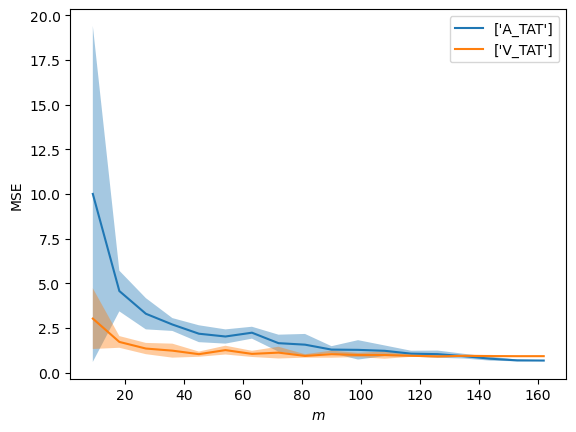

In [30]:
plt.plot(x,MSE.mean(axis=1))
plt.fill_between(x, MSE.mean(axis=1)[:,0]+MSE.std(axis=1)[:,0], y2=MSE.mean(axis=1)[:,0]-MSE.std(axis=1)[:,0],alpha=0.4)
plt.fill_between(x, MSE.mean(axis=1)[:,1]+MSE.std(axis=1)[:,1], y2=MSE.mean(axis=1)[:,1]-MSE.std(axis=1)[:,1],alpha=0.4)
plt.legend(y_labels.values)

plt.ylabel('MSE')
plt.xlabel('$m$')
#plt.yscale('log')

In [31]:
MSE.mean(axis=1)[:,0]+MSE.std(axis=1)[:,0]

array([19.40662099,  5.70395846,  4.16825677,  3.05101559,  2.6485309 ,
        2.41920571,  2.56643637,  2.12241217,  2.16350126,  1.47859676,
        1.81525875,  1.52008846,  1.22376013,  1.23348993,  1.05009624,
        0.88573865,  0.73497281,  0.69301115])

In [32]:
MSE.mean(axis=1)[:,0]-MSE.std(axis=1)[:,0]

array([0.59736241, 3.42807664, 2.41968809, 2.33230704, 1.70388217,
       1.62186384, 1.90089723, 1.17195298, 0.96368122, 1.09572246,
       0.73033042, 0.92155986, 0.89591598, 0.83161744, 0.78788566,
       0.66634298, 0.63105946, 0.65489545])

In [33]:
delta_1p.MSE(X_test,y_test)/reps

tensor([0.0897, 0.2861], dtype=torch.float64, grad_fn=<DivBackward0>)

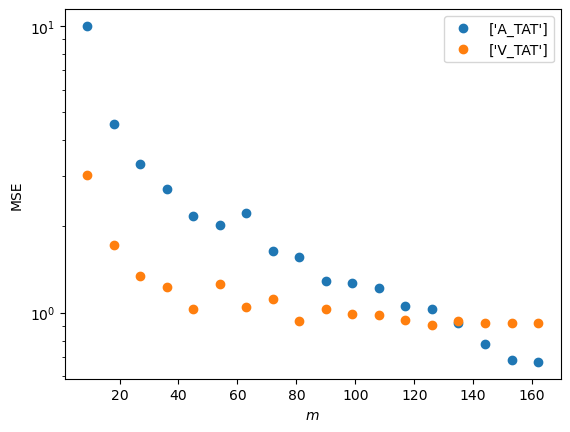

In [34]:
plt.plot(x,MSE.mean(axis=1),'o') 
plt.legend(y_labels.values)

plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

In [35]:
np.hstack((MSE_p,MSE))

array([[[1.13757861e+03, 9.02183329e+01],
        [1.31366450e+03, 1.63524368e+02],
        [6.27617818e+02, 1.35348257e+02],
        [1.81391642e+04, 2.39422671e+02],
        [4.35580854e+03, 8.15707601e+01],
        [4.62898673e+02, 1.33683913e+02],
        [3.83447918e+02, 6.87153083e+01],
        [1.64265700e+03, 7.53123706e+01],
        [1.29912972e+03, 9.29725020e+01],
        [9.01899808e+02, 1.82221500e+02],
        [4.60953783e+00, 2.00036940e+00],
        [5.31860793e+00, 1.96580559e+00],
        [5.77511575e+00, 1.99273637e+00],
        [3.56846691e+01, 2.42479108e+00],
        [1.79252941e+01, 3.72361737e+00],
        [3.51102883e+00, 3.02290177e+00],
        [8.39227842e+00, 3.23043511e+00],
        [4.69974286e+00, 7.80274058e+00],
        [8.27004268e+00, 1.98462633e+00],
        [5.83359950e+00, 2.07713510e+00]],

       [[1.12844393e+02, 7.26866408e+01],
        [2.20583579e+02, 2.64999231e+01],
        [4.39595421e+02, 1.99891943e+01],
        [1.84477117e+02, 1.44101

In [36]:
MSE_p.mean(axis=1)[:,0]+MSE_p.std(axis=1)[:,0]

array([8.17795612e+03, 4.09642344e+02, 6.71553167e+01, 3.65921823e+01,
       1.85344150e+01, 1.10925496e+01, 1.40728664e+01, 8.36626691e+00,
       7.97396839e+00, 6.51005867e+00, 5.06921284e+00, 4.42469984e+00,
       2.79018061e+00, 2.39620417e+00, 2.12521175e+00, 1.97078913e+00,
       9.33358688e-01, 8.03485750e-01])

In [37]:
MSE_p

array([[[1.13757861e+03, 9.02183329e+01],
        [1.31366450e+03, 1.63524368e+02],
        [6.27617818e+02, 1.35348257e+02],
        [1.81391642e+04, 2.39422671e+02],
        [4.35580854e+03, 8.15707601e+01],
        [4.62898673e+02, 1.33683913e+02],
        [3.83447918e+02, 6.87153083e+01],
        [1.64265700e+03, 7.53123706e+01],
        [1.29912972e+03, 9.29725020e+01],
        [9.01899808e+02, 1.82221500e+02]],

       [[1.12844393e+02, 7.26866408e+01],
        [2.20583579e+02, 2.64999231e+01],
        [4.39595421e+02, 1.99891943e+01],
        [1.84477117e+02, 1.44101176e+01],
        [2.04876981e+02, 4.45951636e+01],
        [4.27028194e+01, 1.33068184e+02],
        [5.68334951e+02, 5.86778232e+01],
        [7.35286078e+01, 8.25055552e+01],
        [4.32441361e+02, 6.94187193e+01],
        [1.32900979e+02, 8.28654240e+01]],

       [[7.13912744e+01, 5.10552539e+01],
        [4.43118763e+01, 3.19879938e+01],
        [6.77085571e+01, 3.52969271e+01],
        [2.61327803e+01, 2.022

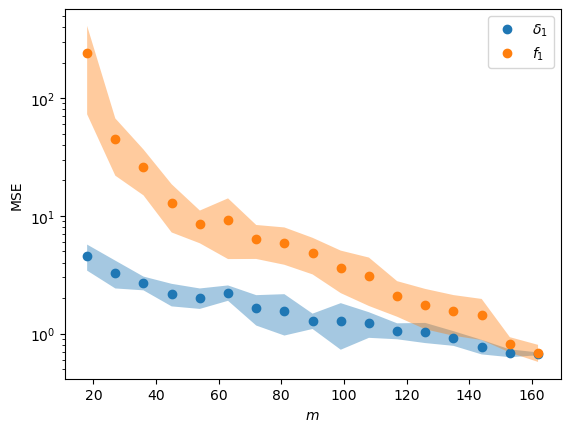

In [38]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[1:,[0,2]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,0]+MSE.std(axis=1)[1:,0], y2=MSE.mean(axis=1)[1:,0]-MSE.std(axis=1)[1:,0],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,0]+MSE_p.std(axis=1)[1:,0], y2=MSE_p.mean(axis=1)[1:,0]-MSE_p.std(axis=1)[1:,0],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

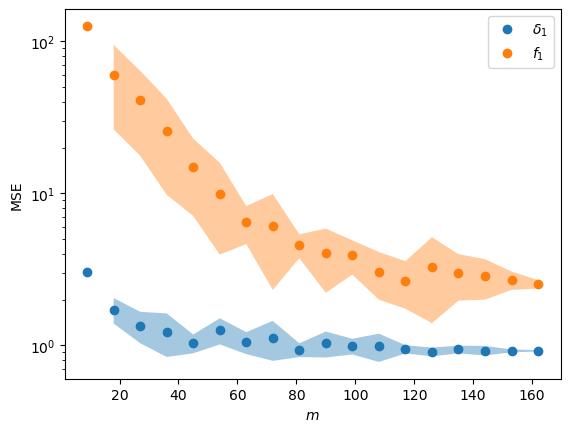

In [39]:
plt.plot(x,np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1)))[:,[1,3]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,1]+MSE.std(axis=1)[1:,1], y2=MSE.mean(axis=1)[1:,1]-MSE.std(axis=1)[1:,1],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,1]+MSE_p.std(axis=1)[1:,1], y2=MSE_p.mean(axis=1)[1:,1]-MSE_p.std(axis=1)[1:,1],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

Text(0.5, 0, '$m$')

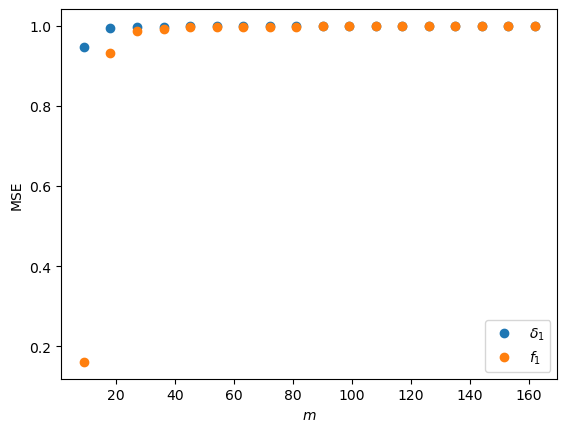

In [40]:
plt.plot(x,np.hstack((R2.mean(axis=1),R2_p.mean(axis=1)))[:,[0,2]],'o') 
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')

Text(0.5, 0, '$m$')

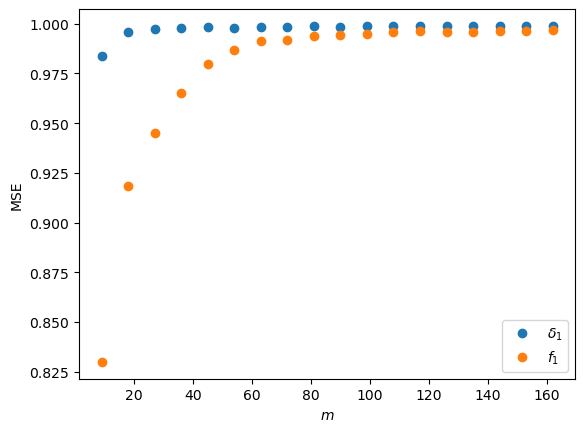

In [41]:
plt.plot(x,np.hstack((R2.mean(axis=1),R2_p.mean(axis=1)))[:,[1,3]],'o') 
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')

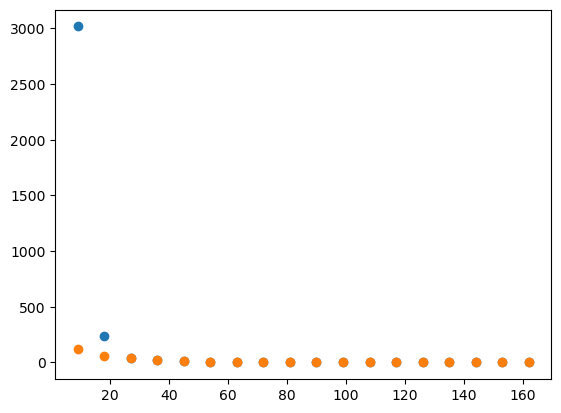

In [42]:
plt.plot(x,MSE_p.mean(axis=1)-MSE.mean(axis=1),'o')


Text(0.5, 0, '$m$')

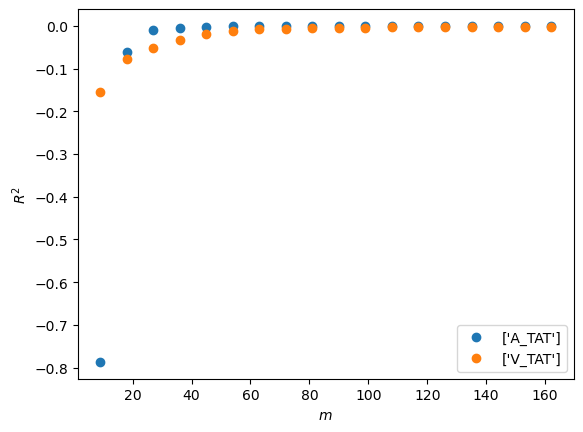

In [43]:
plt.plot(x,R2_p.mean(axis=1)-R2.mean(axis=1),'o')
plt.legend(y_labels.values)
plt.ylabel('$R^2$')
plt.xlabel('$m$')

In [44]:
MSE_p

array([[[1.13757861e+03, 9.02183329e+01],
        [1.31366450e+03, 1.63524368e+02],
        [6.27617818e+02, 1.35348257e+02],
        [1.81391642e+04, 2.39422671e+02],
        [4.35580854e+03, 8.15707601e+01],
        [4.62898673e+02, 1.33683913e+02],
        [3.83447918e+02, 6.87153083e+01],
        [1.64265700e+03, 7.53123706e+01],
        [1.29912972e+03, 9.29725020e+01],
        [9.01899808e+02, 1.82221500e+02]],

       [[1.12844393e+02, 7.26866408e+01],
        [2.20583579e+02, 2.64999231e+01],
        [4.39595421e+02, 1.99891943e+01],
        [1.84477117e+02, 1.44101176e+01],
        [2.04876981e+02, 4.45951636e+01],
        [4.27028194e+01, 1.33068184e+02],
        [5.68334951e+02, 5.86778232e+01],
        [7.35286078e+01, 8.25055552e+01],
        [4.32441361e+02, 6.94187193e+01],
        [1.32900979e+02, 8.28654240e+01]],

       [[7.13912744e+01, 5.10552539e+01],
        [4.43118763e+01, 3.19879938e+01],
        [6.77085571e+01, 3.52969271e+01],
        [2.61327803e+01, 2.022

In [45]:
R2_p-R2

array([[[-3.09418409e-01, -1.16124653e-01],
        [-3.56273685e-01, -2.15044486e-01],
        [-1.64715334e-01, -1.76950766e-01],
        [-4.67476076e+00, -3.14556900e-01],
        [-1.11825835e+00, -9.11917973e-02],
        [-1.24886883e-01, -1.67749780e-01],
        [-8.67604875e-02, -7.84962288e-02],
        [-4.49180497e-01, -1.94351028e-02],
        [-3.41128652e-01, -1.19918715e-01],
        [-2.40551124e-01, -2.39621239e-01]],

       [[-2.97261921e-02, -9.39685760e-02],
        [-5.51529266e-02, -3.21873936e-02],
        [-1.15015901e-01, -2.25952629e-02],
        [-4.73869467e-02, -1.67077861e-02],
        [-4.94666860e-02, -5.22802199e-02],
        [ 2.14599817e-03, -1.76226742e-01],
        [-1.51951462e-01, -7.67198555e-02],
        [-1.48252715e-02, -1.04483833e-01],
        [-1.15424499e-01, -8.99875203e-02],
        [-3.04443802e-02, -1.08162196e-01]],

       [[-1.66884722e-02, -6.71548867e-02],
        [-8.86600945e-03, -4.11844509e-02],
        [-1.77115080e-02, -4

Text(0.5, 0, '$m$')

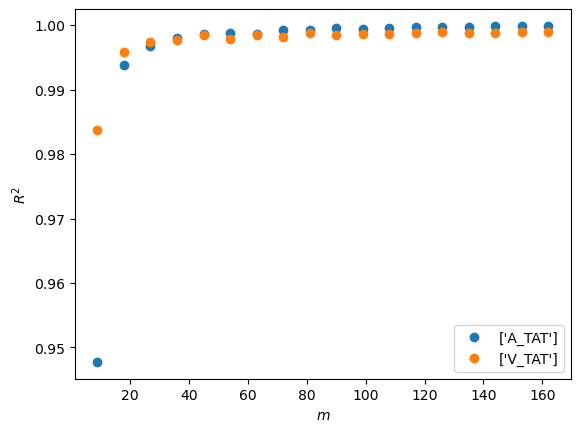

In [46]:
plt.plot(x,R2.mean(axis=1),'o')
plt.legend(y_labels.values)
plt.ylabel('$R^2$')
plt.xlabel('$m$')

In [47]:
p

9

In [48]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE = np.zeros((n,m,2))
R2 = np.zeros((n,m,2))
reps = 5
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            emulator_0 = GPE.ensemble(X0.iloc[a,:],Y0.iloc[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train.iloc[b,:])
            y_adjust = pd.DataFrame((torch.tensor(y_train.iloc[b].values) - m0).detach().numpy())
            delta_1 = GPE.ensemble(X_train.iloc[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE[i,k] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0).detach().numpy())/reps
            R2[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0)/torch.tensor(np.var(y_test.values,axis=0))).detach().numpy()/reps

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


KeyboardInterrupt: 

In [ ]:
x

In [52]:
y = np.linspace(9,180,20)

In [53]:
y

array([  9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,  90.,  99.,
       108., 117., 126., 135., 144., 153., 162., 171., 180.])

In [54]:
xx,yy=np.meshgrid(x,y)

In [55]:
xx[1:,1:].shape

(19, 17)

In [56]:
level = 1

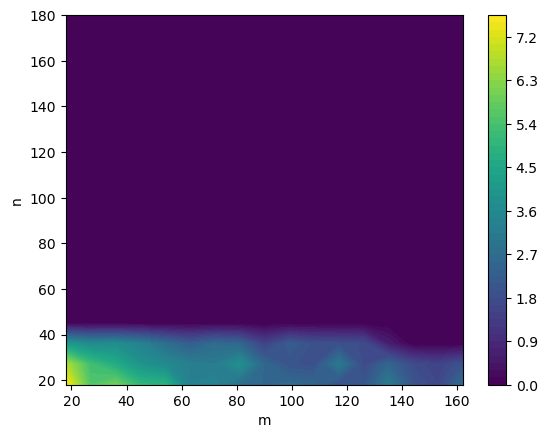

In [57]:
plt.contourf(xx[level:,level:],yy[level:,level:],MSE[level:,level:,1],origin='lower',levels=50)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

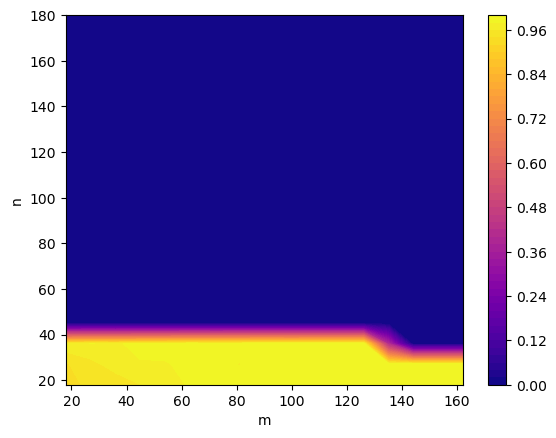

In [58]:
plt.contourf(xx[level:,level:],yy[level:,level:],R2[level:,level:,1],origin='lower',levels=50,cmap='plasma')
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

ValueError: x and y can be no greater than 2D, but have shapes (20,) and (20, 18, 2)

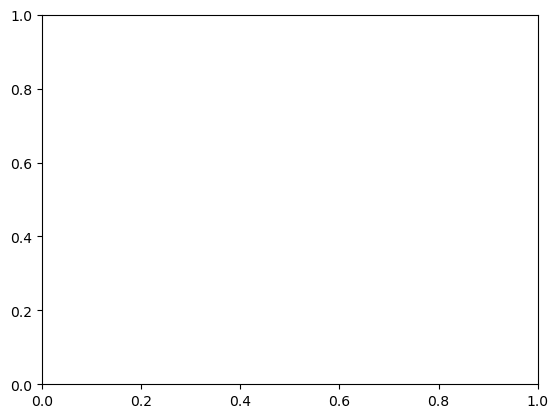

In [59]:
plt.plot(MSE) 
plt.legend(y_labels.values)
plt.ylabel('MSE')
plt.xlabel('$n$')

ValueError: x and y can be no greater than 2D, but have shapes (20,) and (20, 18, 2)

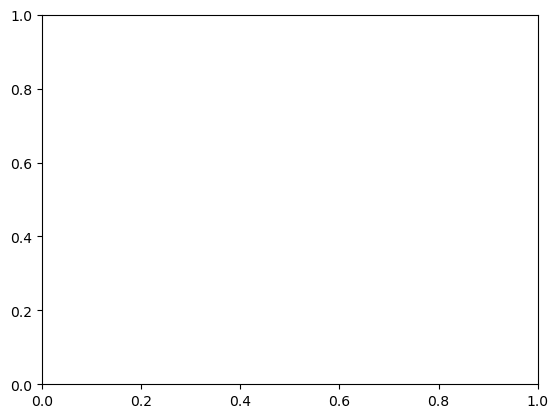

In [60]:
plt.plot(R2)
plt.legend(y_labels.values)
plt.ylabel('$R^2$')
plt.xlabel('$n$')

In [61]:
meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

In [62]:
meshes.copy

<function list.copy()>

In [64]:
t_size = 36
reps = 5
MSE = np.zeros((len(meshes),len(meshes)-1,2))
R2 = np.zeros((len(meshes),len(meshes)-1,2))
for i in (range(len(meshes))):
    val0 = meshes[i]
    
    meshes2 = meshes.copy()
    meshes2.remove(meshes[i])
    
    inputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val0+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val0+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    
    X0 = pd.DataFrame(inputData_0)
    Y0 = pd.DataFrame(outputData_0)
    X0.columns = x_labels
    Y0.columns = y_labels
    emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)

    
    
    for j in (range(len(meshes)-1)):
        val1 = meshes2[j]
        inputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val1+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
        outputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val1+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

        X1 = pd.DataFrame(inputData_1)
        Y1 = pd.DataFrame(outputData_1)
        X1.columns = x_labels
        Y1.columns = y_labels
        # split original dataset in training, validation and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X1,
            Y1,
            test_size=0.1,
            random_state=seed
        )
        for k in range(reps):
            a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)
            m0 = emulator_0.predict(X_train.iloc[a,:])
            y_adjust = pd.DataFrame((torch.tensor(y_train.iloc[a].values) - m0).detach().numpy())
            delta_1 = GPE.ensemble(X_train.iloc[a,:],y_adjust,mean_func="linear",training_iter=500)
            MSE[i,j,:] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0).detach().numpy())/reps
            R2[i,j,:] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test.values))**2).mean(axis=0)/torch.tensor(np.var(y_test.values,axis=0))).detach().numpy()/reps

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


KeyboardInterrupt: 

In [409]:
MSE

array([[[44.55463331, 12.48656521],
        [17.92622688,  5.15833724],
        [ 7.62640622,  2.80905726],
        [ 5.07644527,  2.70281603],
        [ 5.246214  ,  1.60146339],
        [ 5.32124002,  2.41849939],
        [ 4.55666744,  1.48807741],
        [ 1.92135252,  1.23705929],
        [ 2.00908828,  1.14296049],
        [ 2.87102417,  0.9798143 ],
        [ 2.25686773,  1.48637332],
        [ 1.76600875,  0.59752404],
        [ 1.93448489,  0.62956682],
        [ 1.29456654,  0.54854626],
        [ 1.62995983,  1.02670357],
        [ 2.436825  ,  0.51261671],
        [ 1.49343461,  0.47457328],
        [ 1.20447589,  0.48499195]],

       [[26.82143591,  7.92571611],
        [16.85561235,  4.03501625],
        [10.9082474 ,  4.2584192 ],
        [ 5.92937177,  3.33507382],
        [ 6.56181224,  2.29050729],
        [ 6.28407867,  1.59865345],
        [ 7.73829181,  2.23406627],
        [ 4.27066967,  1.39559364],
        [ 5.29380748,  1.12518597],
        [ 2.52395268,  0.8

In [300]:
MSE.mean(axis=1)

array([[3.26187831, 1.79298624],
       [3.2801396 , 2.04670276],
       [2.46450089, 1.79957511],
       [2.61963692, 1.92974022],
       [2.99263129, 2.23654112],
       [2.68465234, 1.73536895],
       [3.33079312, 1.58068215],
       [3.23262693, 1.85341049],
       [2.85003875, 2.29282128],
       [3.18671227, 1.93067693],
       [2.39333175, 1.61376046],
       [2.65521918, 1.81663752],
       [3.33016686, 2.23788735],
       [2.80335246, 1.80253865],
       [3.21383719, 2.08631101],
       [2.66958526, 1.7408499 ],
       [3.3304454 , 1.61397494],
       [2.64060614, 1.57150698]])

Text(0.5, 0, 'Mesh')

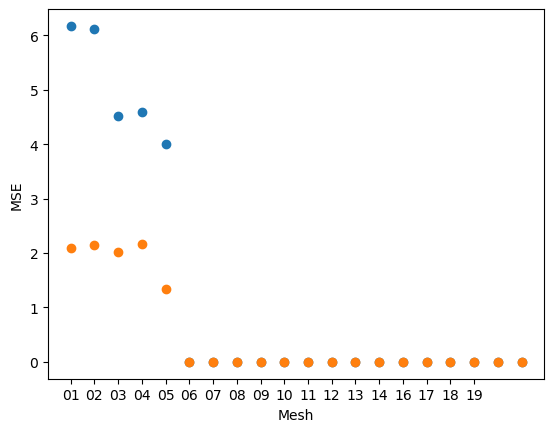

In [410]:
plt.plot(MSE.mean(axis=1),'o')
plt.xticks(range(len(meshes)),meshes)
plt.ylabel('MSE')
plt.xlabel('Mesh')

In [79]:
y_labels

,0
0,A_TAT
1,V_TAT


NameError: name 'meshes' is not defined

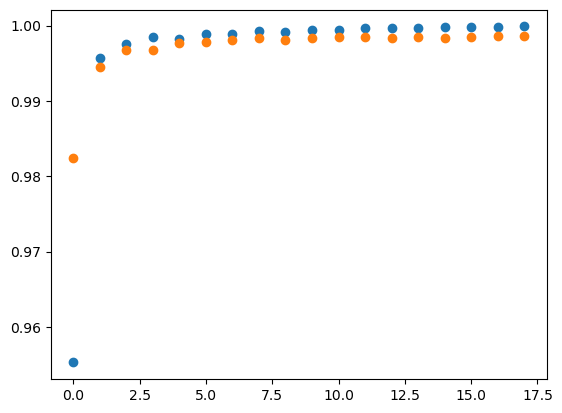

In [80]:
plt.plot(R2.mean(axis=1),'o')
plt.xticks(range(len(meshes)),meshes)
plt.ylabel('$R^2$')
plt.xlabel('$m$')
plt.legend(y_labels)

In [225]:
nDim = X_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(X_train.iloc[:,i]),np.max(X_train.iloc[:,i])])
    print(boundsMaxMin[i])

[0.380213, 0.799439]
[0.200232, 0.499533]
[1.21794, 8.37386]
[0.301329, 1.02696]
[0.201551, 0.497432]
[1.00518, 5.67874]


In [226]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = pd.DataFrame(param_values,columns=x_labels)

C:\Users\pmzcwl\AppData\Local\Temp\ipykernel_15932\145593949.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [229]:
data1

,"(CV_ventricles,)","(k_ventricles,)","(k_FEC,)","(CV_atria,)","(k_atria,)","(k_BB,)"
0,0.380827,0.312908,4.422031,0.654578,0.366395,4.950778
1,0.481540,0.312908,4.422031,0.654578,0.366395,4.950778
2,0.380827,0.376042,4.422031,0.654578,0.366395,4.950778
3,0.380827,0.312908,6.204023,0.654578,0.366395,4.950778
4,0.380827,0.312908,4.422031,0.788508,0.366395,4.950778
...,...,...,...,...,...,...
14331,0.429546,0.209731,7.881192,0.624816,0.349058,5.142467
14332,0.429546,0.209731,7.762392,0.556079,0.349058,5.142467
14333,0.429546,0.209731,7.762392,0.624816,0.388066,5.142467
14334,0.429546,0.209731,7.762392,0.624816,0.349058,4.079050


In [251]:
Ymean_A=delta_1.predict(data1)

In [252]:
Si = []
for i in range(2):
    Si.append(sobol.analyze(problem, Ymean_A[:,i].detach().numpy(), print_to_console=True))

                        ST   ST_conf
(CV_ventricles,)  0.000061  0.000005
(k_ventricles,)   0.006439  0.000486
(k_FEC,)          0.002398  0.000206
(CV_atria,)       0.947955  0.057482
(k_atria,)        0.007983  0.000645
(k_BB,)           0.035140  0.003036
                        S1   S1_conf
(CV_ventricles,)  0.000054  0.000683
(k_ventricles,)   0.006435  0.006865
(k_FEC,)          0.002433  0.003947
(CV_atria,)       0.948018  0.073635
(k_atria,)        0.007970  0.008294
(k_BB,)           0.035140  0.019879
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.486321  0.040826
(k_ventricles,)   0.035319  0.004204
(k_FEC,)          0.425205  0.040547
(CV_atria,)       0.037762  0.003641
(k_atria,)        0.020304  0.001789
(k_BB,)           0.048147  0.005480
                        S1   S1_conf
(CV_ventricles,)  0.486634  0.055083
(k_ventricles,)   0.025084  0.016084
(k_FEC,)          0.365856  0.047679
(CV_atria,)       0.037353

In [253]:
nMod = 2
SiA_first=np.zeros((nDim,nMod))
SiA_total=np.zeros((nDim,nMod))

for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    SiA_first[:,i] =  first_Si.iloc[:,0]
    SiA_total[:,i] =  total_Si.iloc[:,0]


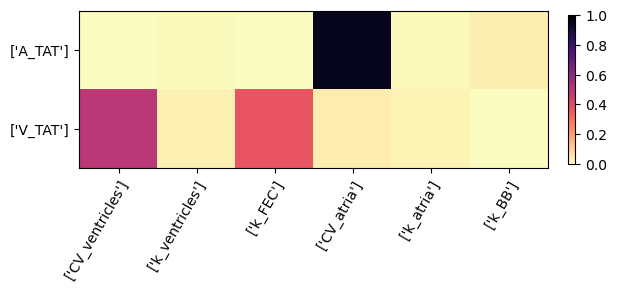

In [254]:
inputs = x_labels.values.tolist()
outputs = y_labels.values.tolist()
fig, ax = plt.subplots()
im = ax.imshow(SiA_first.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

# Distance simulation results

In [2]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/same_X/xlabels_EP.txt',delim_whitespace=True,header=None)

In [3]:
inputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/same_X/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
inputData = pd.DataFrame(inputData)

In [4]:
inputData.columns=x_labels

In [5]:
meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

In [6]:
d=[]
for val in meshes:
    d.append(pd.DataFrame(pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/same_X/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values,columns=['A_TAT','V_TAT']))

In [7]:
np.array(d).shape

(18, 180, 2)

In [8]:
np.array(d)[0:1,:10,0].T

array([[122.17 ],
       [344.156],
       [121.403],
       [165.463],
       [236.003],
       [215.851],
       [146.807],
       [303.375],
       [242.452],
       [154.642]])

In [9]:
np.array(d)[1:,:10,0].T

array([[ 92.1714,  88.244 ,  85.6108,  79.4421,  80.5874,  80.5269,
         78.327 ,  83.8367, 102.9   ,  96.2141,  72.4446,  91.4856,
         92.5334,  77.0678,  92.1445,  71.1917,  68.4627],
       [271.855 , 256.528 , 246.696 , 229.904 , 226.737 , 223.398 ,
        214.155 , 229.562 , 289.18  , 272.789 , 206.326 , 266.187 ,
        262.413 , 220.837 , 259.882 , 198.642 , 201.555 ],
       [100.9   ,  91.258 ,  86.587 ,  81.1279,  76.5798,  76.0823,
         74.3034,  81.6747,  98.4956,  96.7417,  73.1786,  93.1645,
         93.1445,  76.8222,  89.8862,  69.8923,  71.1007],
       [130.977 , 125.36  , 121.907 , 113.008 , 111.484 , 105.198 ,
        103.231 , 115.022 , 143.27  , 133.531 , 100.26  , 131.088 ,
        129.75  , 107.079 , 126.359 ,  95.0423, 100.978 ],
       [194.76  , 188.949 , 180.281 , 169.68  , 160.461 , 160.004 ,
        157.097 , 170.86  , 209.465 , 191.31  , 149.774 , 185.992 ,
        191.579 , 157.689 , 178.638 , 139.986 , 149.467 ],
       [164.424 , 157.197

Text(0, 0.5, 'A_TAT')

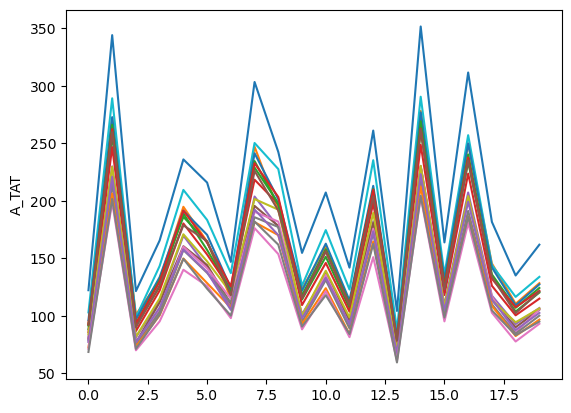

In [10]:
plt.plot(np.array(d)[:,0:20,0].T)
plt.ylabel('A_TAT')

In [11]:
np.array(d)[10,:,0].T.shape

(180,)

In [12]:
# split original dataset in training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    np.log(np.array(d)[0,:,0].T.reshape(-1, 1)),
    np.log(np.array(d)[1,:,0].T.reshape(-1, 1)) ,
    test_size=0.1,
    random_state=seed
)

In [13]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train,y_train )

In [14]:
reg.score(X_test,y_test)

0.9950253901083755

In [15]:
print(reg)

LinearRegression()


In [16]:
reg.coef_

array([[1.00622753]])

In [17]:
reg.intercept_

array([-0.26979267])

In [18]:
coeffs = np.zeros(17)
inter = np.zeros(17)
scores = np.zeros(17)
for i in range(17):
    # split original dataset in training, validation and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        
        np.log(np.array(d)[i+1,:,1].T.reshape(-1, 1)) ,
        np.log(np.array(d)[0,:,1].T.reshape(-1, 1)),
        test_size=0.1,
        random_state=seed
    )
    reg = LinearRegression().fit(X_train,y_train )
    coeffs[i]=reg.coef_
    inter[i]=reg.intercept_
    scores[i]=1-((np.exp(reg.predict(X_test))-np.exp(y_test))**2).mean()/np.var(np.exp(y_test))

In [19]:
1-((np.exp(reg.predict(X_test))-np.exp(y_test))**2).mean()/np.var(np.exp(y_test))

0.9759187427249033

In [20]:
meshes2 = meshes.copy()
meshes2.remove(meshes[0])
     

Text(0.5, 0, 'Mesh')

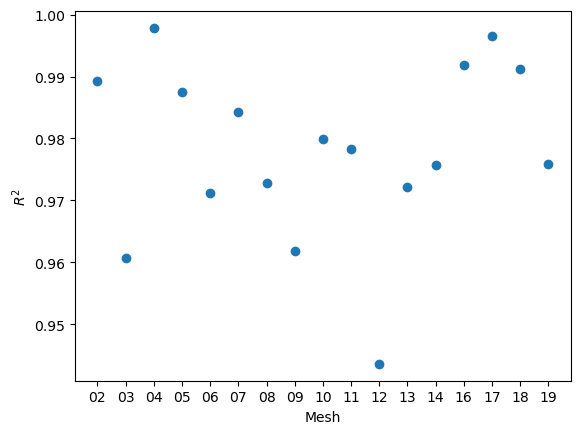

In [21]:
plt.plot(scores,'o')
plt.xticks(range(len(meshes2)),meshes2)
plt.ylabel('$R^2$')
plt.xlabel('Mesh')

Text(0.5, 0, 'Mesh')

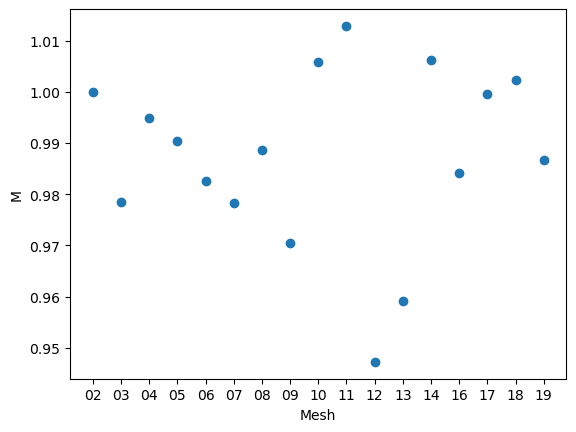

In [22]:
plt.plot(coeffs,'o')
plt.xticks(range(len(meshes2)),meshes2)
plt.ylabel('M')
plt.xlabel('Mesh')

Text(0.5, 0, 'Mesh')

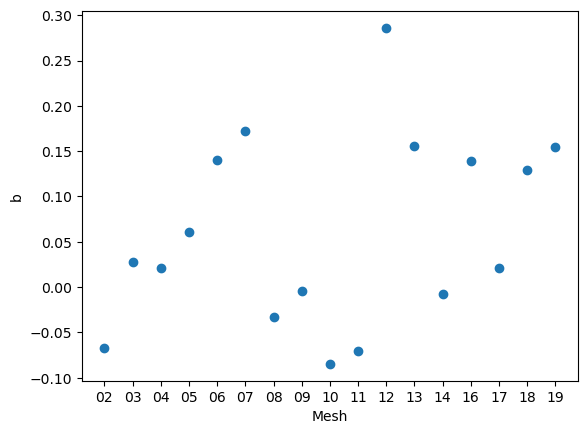

In [23]:
plt.plot(inter,'o')
plt.xticks(range(len(meshes2)),meshes2)
plt.ylabel('b')
plt.xlabel('Mesh')

In [24]:
plt.scatter(distance.iloc[:,0],scores)

NameError: name 'distance' is not defined

In [25]:
162/18

9.0

In [26]:
x=np.linspace(1,145,17)

In [27]:
x

array([  1.,  10.,  19.,  28.,  37.,  46.,  55.,  64.,  73.,  82.,  91.,
       100., 109., 118., 127., 136., 145.])

In [28]:
X_train

array([[4.78669142],
       [4.61428849],
       [4.22986419],
       [4.19693575],
       [4.69767644],
       [4.77760974],
       [4.32341187],
       [4.95150081],
       [4.96836781],
       [4.76097664],
       [4.29004566],
       [4.59022709],
       [4.44466922],
       [4.44359317],
       [4.53614374],
       [4.37033227],
       [4.85164738],
       [4.60899287],
       [4.23040546],
       [5.13011763],
       [4.42554818],
       [4.98485242],
       [4.47829885],
       [4.49681408],
       [4.48169096],
       [4.29984268],
       [4.51648978],
       [4.38502339],
       [4.42899609],
       [4.72510202],
       [4.83789965],
       [4.35152877],
       [4.65133787],
       [4.96936181],
       [4.45647526],
       [4.64175281],
       [4.56459712],
       [4.71245385],
       [4.58299104],
       [4.54039804],
       [4.45686737],
       [4.64665756],
       [4.46575063],
       [4.19545004],
       [4.31926254],
       [4.30248005],
       [4.28591076],
       [4.733

In [29]:
# split original dataset in training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    np.log(np.array(d)[0,:,0].T.reshape(-1, 1)),
    np.log(np.array(d)[1,:,0].T.reshape(-1, 1)) ,
    test_size=0.1,
    random_state=seed
)

In [30]:
coeffs = np.zeros(17)
inter = np.zeros(17)
scores = np.zeros(17)
for i in range(17):
    # split original dataset in training, validation and testing sets
    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        X_train,
        y_train,
        test_size=int(162-x[i]),
        random_state=seed
    )
    reg = LinearRegression().fit(X_train2,y_train2 )
    coeffs[i]=reg.coef_
    inter[i]=reg.intercept_
    scores[i]=1-((np.exp(reg.predict(X_test))-np.exp(y_test))**2).mean()/np.var(np.exp(y_test))

Text(0.5, 0, 'Training Data Size')

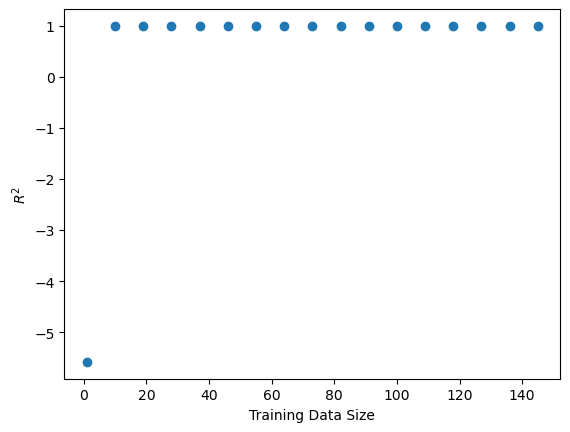

In [31]:
plt.plot(x,scores,'o')

plt.ylabel('$R^2$')
plt.xlabel('Training Data Size')

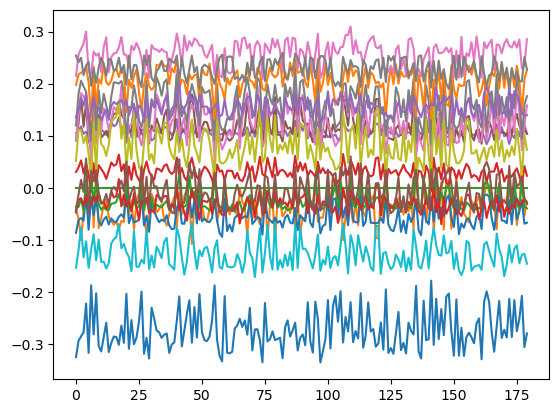

In [32]:
plt.plot(np.log(np.array(d)[2:3,:,0].T)-np.log(np.array(d)[:,:,0].T))


In [33]:
len(d)

18

In [34]:
((d[0]-d[1])**2).mean(axis=0)

A_TAT    1849.158453
V_TAT      61.114784
dtype: float64

In [35]:
import scipy
A_dist = scipy.spatial.distance_matrix(np.array(d)[:,:,0],np.array(d)[:,:,0])
V_dist = scipy.spatial.distance_matrix(np.array(d)[:,:,1],np.array(d)[:,:,1])

In [36]:
meshes2=['02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

In [37]:
distance = np.zeros((len(meshes2),2))
for i in range(len(meshes2)):
    distance[i] = ((d[0]-d[i+1])**2).mean(axis=0)
distance=pd.DataFrame(distance,index=meshes2)    

In [38]:
distance

,0,1
02,1849.158453,61.114784
03,2319.919882,87.823091
04,2791.893038,4.782684
05,4127.244662,20.807054
06,4311.096907,52.738326
07,4443.859023,66.117801
08,5015.269410,122.321744
09,3608.411885,345.258816
10,773.147162,50.660757
11,1567.393611,8.966316


In [39]:
distance.idxmin()[0]

'10'

In [40]:
np.where(np.array(meshes)==distance.idxmin()[0])

(array([9]),)

In [41]:
d[9]

,A_TAT,V_TAT
0,102.9000,128.5340
1,289.1800,96.8079
2,98.4956,86.9849
3,143.2700,114.1610
4,209.4650,117.6030
...,...,...
175,99.6627,101.3760
176,230.3100,168.0270
177,203.9690,105.7230
178,160.9550,113.3850


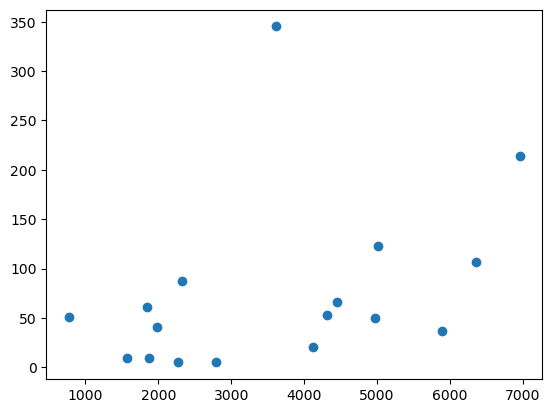

In [42]:
plt.scatter(distance.iloc[:,0],distance.iloc[:,1])

In [43]:
np.corrcoef(distance.iloc[:,0],distance.iloc[:,1])[0,1]

0.3799073603139398

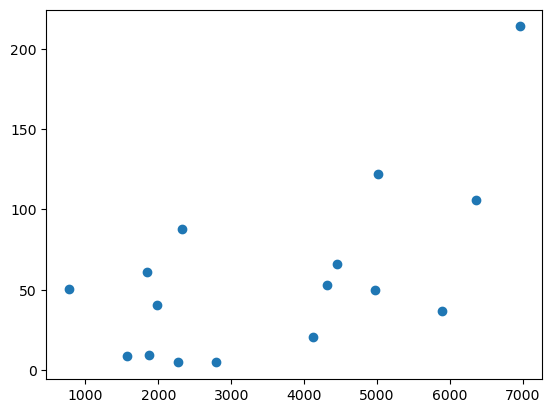

In [44]:
plt.scatter(distance.iloc[:,0].drop('09'),distance.iloc[:,1].drop('09'))


In [45]:
np.corrcoef(distance.iloc[:,0].drop('09'),distance.iloc[:,1].drop('09'))

array([[1.        , 0.62683642],
       [0.62683642, 1.        ]])

In [46]:
mode_weights = pd.read_csv(r'/Users/pmzcwl/Documents/GitHub/Calibration/modes_weights.csv',index_col=0,delim_whitespace=False,header=0)

In [47]:
mode_weights=mode_weights.drop(15,axis=0)

In [48]:
mode_weights

,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9,Mode10,Mode11,Mode12,Mode13,Mode14,Mode15,Mode16,Mode17,Mode18
Mesh_ID,,,,,,,,,,,,,,,,,,
1,-26.526282,-21.987510,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
2,-16.902798,23.644504,19.452896,-24.329813,-25.447350,20.415574,-8.318264,-11.552292,4.878743,-0.590770,0.058564,-5.180545,0.202458,5.183101,1.159655,-4.124027,-1.797792,1.839387
3,14.528402,16.328970,-5.269040,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703,-3.384570,6.019192,6.381015,12.668005,2.272989,-7.823127,-3.264168,-0.556074,-3.457493
4,-15.076964,28.889168,8.644859,4.758042,1.301095,5.983310,-12.741057,29.428944,0.900375,-3.117595,5.360741,-4.384879,-5.052080,-0.322429,1.764566,0.281199,0.379901,1.411104
5,-3.839848,-47.723637,7.042452,-4.914959,-4.014415,20.366371,1.061045,3.789887,-4.468229,4.581192,-5.260154,-1.138816,0.222769,-9.960540,-3.465097,8.679472,-5.080536,-3.130734
6,18.372208,-13.173184,-10.191443,-24.148353,5.156296,-5.613573,5.256249,6.128060,2.273913,-3.308190,-1.089152,5.115009,-2.514505,15.535679,-6.383510,4.925573,-2.114735,-5.143046
7,-34.355273,-16.804885,-6.838693,-12.785964,5.546781,-11.206395,-10.998304,2.434263,-4.587426,1.445966,-7.883546,-10.294014,11.979958,-1.239739,-1.025227,-5.488834,6.809864,-5.501627
8,-25.433101,7.377060,16.518874,10.553323,20.454561,-3.834116,8.557983,-6.411704,-8.757667,-9.300747,-1.650785,-11.269317,3.099298,4.335249,5.748891,3.315503,-8.408521,3.104817
9,23.260333,-15.185501,34.509394,-5.474826,-7.066281,-10.593615,5.997680,0.089632,-18.393991,4.721930,14.410537,1.322375,0.474351,-0.843182,-6.305262,-3.498095,1.827012,3.739217


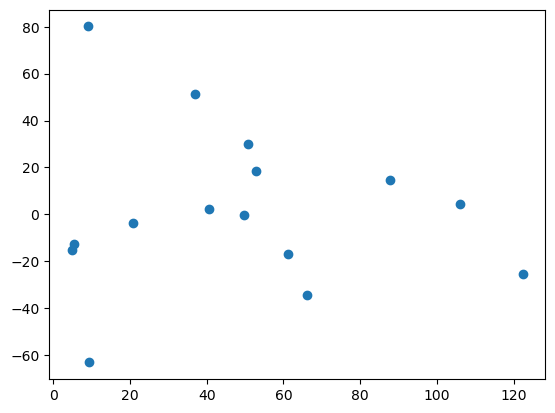

In [49]:
plt.scatter(distance.iloc[:,1].drop(['09','18']),mode_weights.iloc[1:,0].drop([9,18]))



In [50]:
corr_A=np.zeros(18)
corr_V=np.zeros(18)
for i in range(18):
    corr_A[i]=(np.corrcoef(distance.iloc[:,0].drop(['09','18']),mode_weights.iloc[1:,i].drop([9,18]))[0,1])
    corr_V[i]=(np.corrcoef(distance.iloc[:,1].drop(['09','18']),mode_weights.iloc[1:,i].drop([9,18]))[0,1])

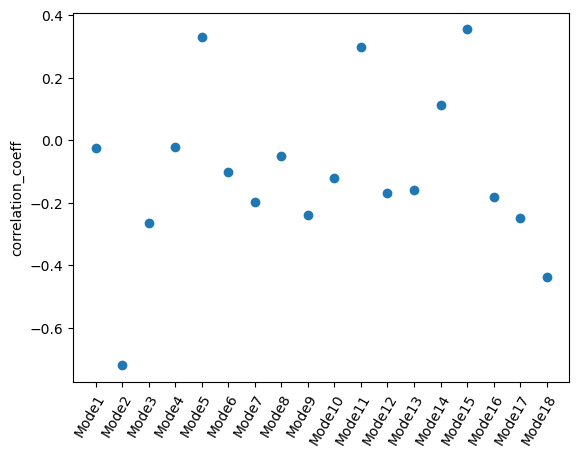

In [51]:

fig, ax = plt.subplots()
im = plt.scatter(mode_weights.columns,corr_A)
plt.ylabel('correlation_coeff')
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

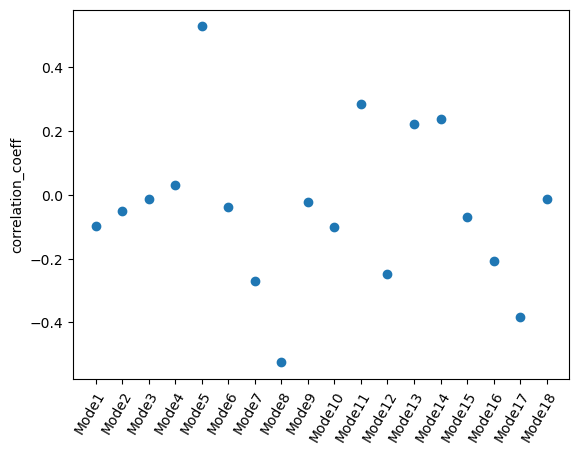

In [52]:

fig, ax = plt.subplots()
im = plt.scatter(mode_weights.columns,corr_V)
plt.ylabel('correlation_coeff')
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [53]:
corr_A=np.zeros(18)
corr_V=np.zeros(18)
for i in range(18):
    corr_A[i]=(np.corrcoef(distance.iloc[:,0],mode_weights.iloc[1:,i])[0,1])
    corr_V[i]=(np.corrcoef(distance.iloc[:,1],mode_weights.iloc[1:,i])[0,1])

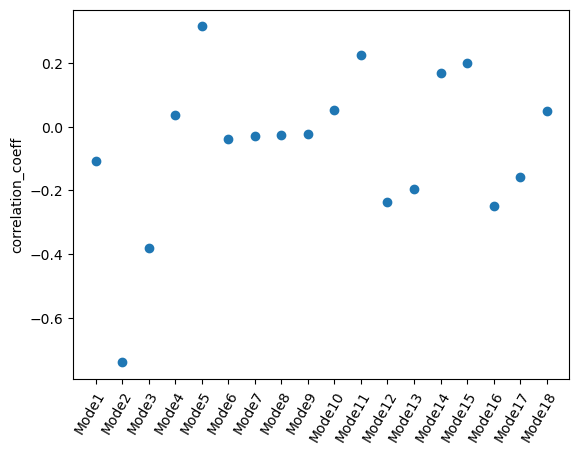

In [54]:

fig, ax = plt.subplots()
im = plt.scatter(mode_weights.columns,corr_A)
plt.ylabel('correlation_coeff')
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

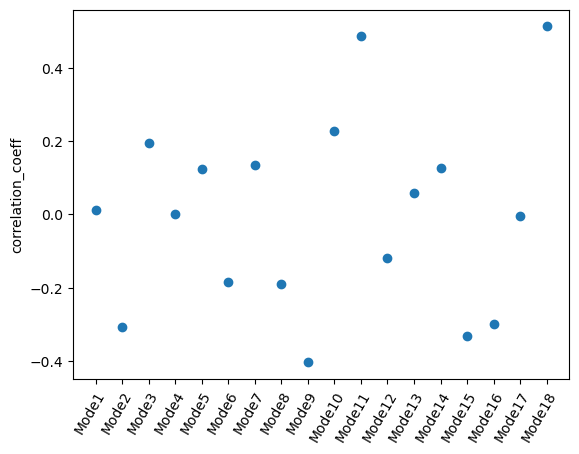

In [55]:

fig, ax = plt.subplots()
im = plt.scatter(mode_weights.columns,corr_V)
plt.ylabel('correlation_coeff')
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [56]:
np.array(d)[0,:,:].shape

(180, 2)

In [57]:
x_0 = np.random.randint(179)

In [58]:
x_0

42

In [59]:
b=np.log(np.array(d)[1:18,x_0,:]/np.array(d)[0,x_0,:])

In [60]:
(np.exp((np.log(np.array(d)[0,:,:])+b[1]))-np.array(d)[1,:,:]).mean(axis=0)

array([-9.96762257, -5.90294692])

In [61]:
np.var(np.array(d)[i,:,:],axis=0)

array([1949.79692726,  539.75843633])

In [62]:
np.array(d).shape

(18, 180, 2)

In [63]:
MSE.shape

NameError: name 'MSE' is not defined

In [64]:
MSE = np.zeros((17,2))
R2 = np.zeros((17,2))
for i in range(17):
    MSE[i,:]=((np.exp((np.log(np.array(d)[0,:,:])+b[i]))-np.array(d)[i+1,:,:])**2).mean(axis=0)
    R2[i,:]=1-((np.exp((np.log(np.array(d)[0,:,:])+b[i]))-np.array(d)[i+1,:,:])**2).mean(axis=0)/np.var(np.array(d)[i+1,:,:],axis=0)

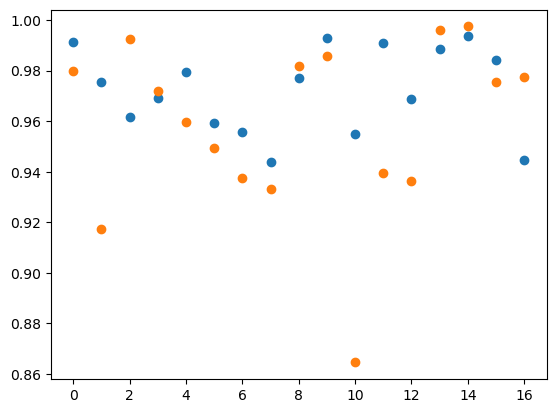

In [65]:
plt.plot(R2,'o')

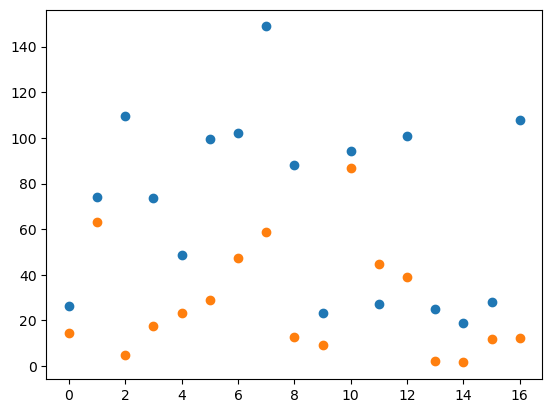

In [66]:
plt.plot(MSE,'o')

In [67]:
MSE = np.zeros((17,2,180))
R2 = np.zeros((17,2,180))
for j in range(180):
    x_0=j
    b=np.log(np.array(d)[1:18,x_0,:]/np.array(d)[0,x_0,:])
    print(b[0])
    for i in range(17): 
        MSE[i,:,j]=((np.exp((np.log(np.array(d)[0,:,:])+b[i]))-np.array(d)[i+1,:,:])**2).mean(axis=0)
        R2[i,:,j]=1-((np.exp((np.log(np.array(d)[0,:,:])+b[i]))-np.array(d)[i+1,:,:])**2).mean(axis=0)/np.var(np.array(d)[i+1,:,:],axis=0)

[-0.28176363  0.07004043]
[-0.23582621  0.08449165]
[-0.18498566  0.06733732]
[-0.23372587  0.08199718]
[-0.19207649  0.07206716]
[-0.2721399   0.07069099]
[-0.2439693   0.07815957]
[-0.20525749  0.07162386]
[-0.23313652  0.0760636 ]
[-0.22657346  0.0668096 ]
[-0.25525754  0.0822035 ]
[-0.25521209  0.05753525]
[-0.23631141  0.06898593]
[-0.25962397  0.01285588]
[-0.23436267  0.07629445]
[-0.21468626  0.07121699]
[-0.22095499  0.08669454]
[-0.22198656  0.08403011]
[-0.20133511  0.06835143]
[-0.23174437  0.06170451]
[-0.21906749  0.022045  ]
[-0.25730853  0.07482454]
[-0.22995431  0.0327882 ]
[-0.2211777   0.06602762]
[-0.25964264  0.06753348]
[-0.24754859  0.07360958]
[-0.23571532  0.05376268]
[-0.25736778  0.02437912]
[-0.20260946  0.08562517]
[-0.27942977  0.0680057 ]
[-0.21827251  0.06054238]
[-0.22585642  0.06792222]
[-0.22676683  0.08388483]
[-0.2366114   0.07421717]
[-0.25675797  0.0786973 ]
[-0.22171538  0.08211637]
[-0.20715368  0.06893228]
[-0.26587388  0.06862922]
[-0.2682821 

([<matplotlib.axis.XTick at 0x2b1147ad0>,
 [Text(0, 0, '02'),
  Text(1, 0, '03'),
  Text(2, 0, '04'),
  Text(3, 0, '05'),
  Text(4, 0, '06'),
  Text(5, 0, '07'),
  Text(6, 0, '08'),
  Text(7, 0, '09'),
  Text(8, 0, '10'),
  Text(9, 0, '11'),
  Text(10, 0, '12'),
  Text(11, 0, '13'),
  Text(12, 0, '14'),
  Text(13, 0, '16'),
  Text(14, 0, '17'),
  Text(15, 0, '18'),
  Text(16, 0, '19')])

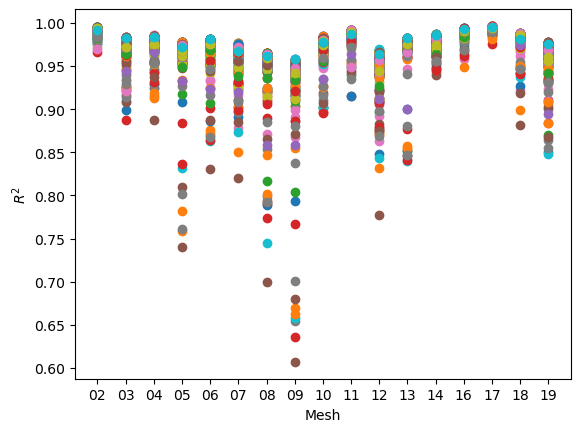

In [80]:
#plt.plot(R2.mean(axis=1),'o')
fig, ax = plt.subplots()
im = plt.plot(R2.mean(axis=1),'o')
plt.ylabel('$R^2$')
plt.xlabel('Mesh')
plt.xticks(range(len(meshes2)),meshes2)

In [213]:
R2.mean(axis=1).shape

(17, 180)

In [218]:
R2)

SyntaxError: unmatched ')' (3774088394.py, line 1)

In [220]:
R2

array([[[0.99348298, 0.99348298, 0.99348298, ..., 0.99348298,
         0.99348298, 0.99348298],
        [0.99630398, 0.99630398, 0.99630398, ..., 0.99630398,
         0.99630398, 0.99630398]],

       [[0.98425338, 0.98425338, 0.98425338, ..., 0.98425338,
         0.98425338, 0.98425338],
        [0.98080039, 0.98080039, 0.98080039, ..., 0.98080039,
         0.98080039, 0.98080039]],

       [[0.97195114, 0.97195114, 0.97195114, ..., 0.97195114,
         0.97195114, 0.97195114],
        [0.99262063, 0.99262063, 0.99262063, ..., 0.99262063,
         0.99262063, 0.99262063]],

       ...,

       [[0.99451155, 0.99451155, 0.99451155, ..., 0.99451155,
         0.99451155, 0.99451155],
        [0.99823132, 0.99823132, 0.99823132, ..., 0.99823132,
         0.99823132, 0.99823132]],

       [[0.98379488, 0.98379488, 0.98379488, ..., 0.98379488,
         0.98379488, 0.98379488],
        [0.98905419, 0.98905419, 0.98905419, ..., 0.98905419,
         0.98905419, 0.98905419]],

       [[0.967138